In [1]:
#imports
import base64
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import prince
from kmodes.kmodes import KModes
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from google.oauth2 import service_account
from google.cloud import bigquery
from tabulate import tabulate
import db_dtypes
import warnings
warnings.filterwarnings("ignore")

In [2]:
# separação de variaveis por utilização
sintomas = ['B0011', 'B0012', 'B0013', 'B0014', 'B0015', 'B0016', 'B0017', 'B0018', 'B0019', 'B00110', 'B00111', 'B00112', 'B00113']
sintomas_suspeita = ['B0011', 'B0012', 'B0014']
fizeram_teste = 'B008'
resultado_covid = ['B009B', 'B009D', 'B009F']
doencas = ['B0101', 'B0102', 'B0103', 'B0104', 'B0105', 'B0106']
idade = 'A002'
raca = 'A004'
estado = 'sigla_uf'
escolaridade = 'A005'
sexo = 'A003'
situacao_domicilio = 'V1022'
providencia_tomada_sintomas = ['B0031', 'B0032', 'B0033', 'B0034', 'B0035', 'B0036', 'B0037']
local_buscou_atendimento = ['B0044', 'B0045', 'B0046']
internacao = ['B005', 'B006']
renda = 'C01011'
colunas_consulta = sintomas + sintomas_suspeita + [fizeram_teste] + resultado_covid + doencas +[idade] + [raca] + [estado] + [escolaridade] + [sexo] + [situacao_domicilio] + providencia_tomada_sintomas + local_buscou_atendimento + internacao + [renda]
colunas_string = ','.join(colunas_consulta)
print(colunas_string)

B0011,B0012,B0013,B0014,B0015,B0016,B0017,B0018,B0019,B00110,B00111,B00112,B00113,B0011,B0012,B0014,B008,B009B,B009D,B009F,B0101,B0102,B0103,B0104,B0105,B0106,A002,A004,sigla_uf,A005,A003,V1022,B0031,B0032,B0033,B0034,B0035,B0036,B0037,B0044,B0045,B0046,B005,B006,C01011


In [ ]:
#Utilizamos a integração com Bigquery para realizar as análises, mas caso não seja desejável a replicação da base no Bigquery, é possível a realização das análises usando as bases em CSV
#LINK CSVs: https://www.ibge.gov.br/estatisticas/investigacoes-experimentais/estatisticas-experimentais/27946-divulgacao-semanal-pnadcovid1?t=downloads&utm_source=covid19&utm_medium=hotsite&utm_campaign=covid_19


#dados_setembro = pd.read_csv('PNAD_COVID_092020.csv', dtype=str)
#dados_outubro = pd.read_csv('PNAD_COVID_102020.csv', dtype=str)
#dados_novembro = pd.read_csv('PNAD_COVID_112020.csv', dtype=str)
#dados = pd.concat([dados_setembro, dados_outubro, dados_novembro])
#dados.info()

In [3]:
project = 'analise-pnad-ibge-fase3-fiap'
location = 'US'
credentials = service_account.Credentials.from_service_account_file('analise-pnad-ibge-fase3-fiap-50b032e6825b.json')
client = bigquery.Client(credentials=credentials, project=project, location=location)

# Consultar dados no BigQuery
query = f"""
SELECT {colunas_string} FROM basedosdados.br_ibge_pnad_covid.microdados WHERE mes in (9,10,11)
"""
query_job = client.query(query)

# Convertendo os resultados para um DataFrame do pandas
dados = query_job.to_dataframe()

In [4]:
#funções de data feature
def convertCategoricaltoBool(value):
    if(value == '1'): return True
    else: return False
def verify_covid(values):
    return (values[resultado_covid[0]] or values[resultado_covid[1]] or values[resultado_covid[2]])
def grafico_barras_empilhadas(df, eixox, eixoy, titulo):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(df.index, df[False], label='False')
    ax.bar(df.index, df[True], bottom=df[False], label='True')
    ax.set_ylabel(eixoy)
    ax.set_xlabel(eixox)
    ax.set_title(titulo)
    ax.legend()
    plt.xticks(rotation=45)
    plt.show()

## 1. Principais Sintomas:
- Frequência dos sintomas
    - na população geral
    - nos casos que apresentaram algum sintoma
    - nos casos positivos de covid
- Correlação entre sintomas


*todas as perguntar utilizadas foram convertidas para valores booleanos, onde 1 é true e os demais valores representam false*

In [5]:
#prepado da base de dados necessária para análises de sintomas
base_analise_sintomas = pd.DataFrame()
base_analise_sintomas[sintomas + resultado_covid] = dados[sintomas + resultado_covid].copy().map(convertCategoricaltoBool)
base_analise_sintomas[sintomas + resultado_covid] = base_analise_sintomas[sintomas + resultado_covid].astype(bool)
base_analise_sintomas['positivo_covid'] = base_analise_sintomas[resultado_covid].apply(verify_covid, axis=1)
base_analise_sintomas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149197 entries, 0 to 1149196
Data columns (total 17 columns):
 #   Column          Non-Null Count    Dtype
---  ------          --------------    -----
 0   B0011           1149197 non-null  bool 
 1   B0012           1149197 non-null  bool 
 2   B0013           1149197 non-null  bool 
 3   B0014           1149197 non-null  bool 
 4   B0015           1149197 non-null  bool 
 5   B0016           1149197 non-null  bool 
 6   B0017           1149197 non-null  bool 
 7   B0018           1149197 non-null  bool 
 8   B0019           1149197 non-null  bool 
 9   B00110          1149197 non-null  bool 
 10  B00111          1149197 non-null  bool 
 11  B00112          1149197 non-null  bool 
 12  B00113          1149197 non-null  bool 
 13  B009B           1149197 non-null  bool 
 14  B009D           1149197 non-null  bool 
 15  B009F           1149197 non-null  bool 
 16  positivo_covid  1149197 non-null  bool 
dtypes: bool(17)
memory usage: 1

B0011   False  True 
B0011   99.22   0.78
B0012   98.66   1.34
B0013   98.91   1.09
B0014   99.58   0.42
B0015   98.35   1.65
B0016   99.70   0.30
B0017   99.66   0.34
B0018   98.60   1.40
B0019   99.29   0.71
B00110  99.68   0.32
B00111  99.62   0.38
B00112  99.05   0.95
B00113  99.63   0.37


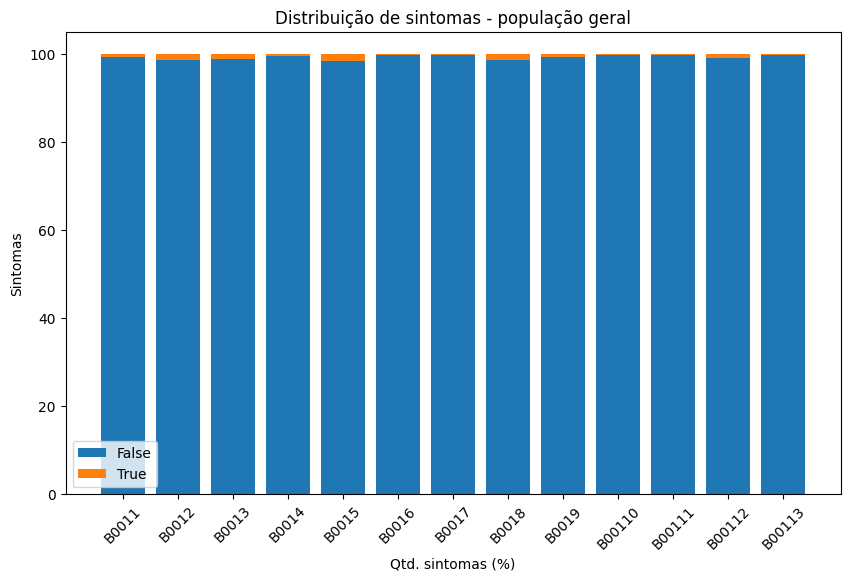

In [6]:
#Frequência dos sintomas de modo geral na população
frequencia_sintomas_geral = pd.DataFrame()
for sintoma in sintomas:
    frequencia_sintomas_geral[sintoma] = base_analise_sintomas[sintoma].value_counts(normalize=True) * 100
frequencia_sintomas_geral = frequencia_sintomas_geral.T.round(2)
print(frequencia_sintomas_geral)

grafico_barras_empilhadas(frequencia_sintomas_geral, 'Qtd. sintomas (%)', 'Sintomas', 'Distribuição de sintomas - população geral')

B0011   False  True 
B0011   79.93  20.07
B0012   65.80  34.20
B0013   72.06  27.94
B0014   89.32  10.68
B0015   57.82  42.18
B0016   92.33   7.67
B0017   91.19   8.81
B0018   64.09  35.91
B0019   81.74  18.26
B00110  91.83   8.17
B00111  90.18   9.82
B00112  75.79  24.21
B00113  90.43   9.57


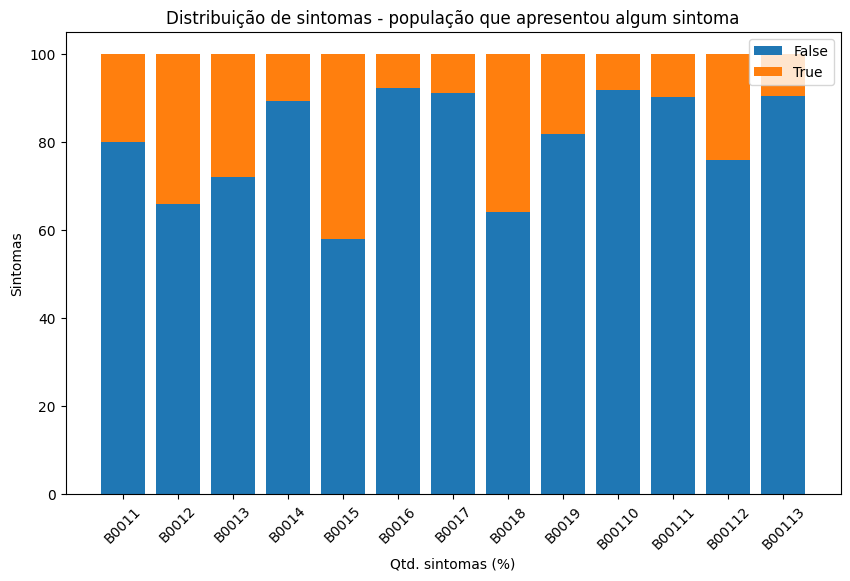

In [7]:
#Frequência dos sintomas nos casos que apresentam algum sintoma
base_analise_sintomas_algum_sintoma = base_analise_sintomas[base_analise_sintomas[sintomas].any(axis=1)]
frequencia_sintomas_algum_sintoma = pd.DataFrame()
for sintoma in sintomas:
    frequencia_sintomas_algum_sintoma[sintoma] = base_analise_sintomas_algum_sintoma[sintoma].value_counts(normalize=True) * 100
frequencia_sintomas_algum_sintoma = frequencia_sintomas_algum_sintoma.T.round(2)
print(frequencia_sintomas_algum_sintoma)

grafico_barras_empilhadas(frequencia_sintomas_algum_sintoma, 'Qtd. sintomas (%)', 'Sintomas', 'Distribuição de sintomas - população que apresentou algum sintoma')

B0011   False  True 
B0011   94.70   5.30
B0012   94.31   5.69
B0013   95.21   4.79
B0014   96.80   3.20
B0015   93.31   6.69
B0016   97.51   2.49
B0017   97.41   2.59
B0018   95.61   4.39
B0019   95.04   4.96
B00110  97.58   2.42
B00111  94.98   5.02
B00112  94.54   5.46
B00113  97.63   2.37


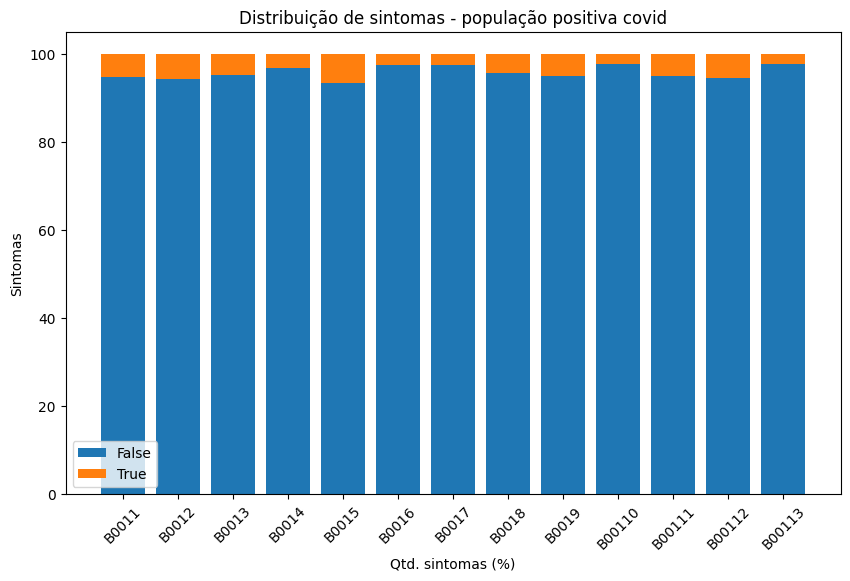

In [8]:
#Frequência dos sintomas nos casos positivos
base_analise_sintomas_casos_positivos = base_analise_sintomas[base_analise_sintomas['positivo_covid'] == True]
frequencia_sintomas_casos_positivos = pd.DataFrame()
for sintoma in sintomas:
    frequencia_sintomas_casos_positivos[sintoma] = base_analise_sintomas_casos_positivos[sintoma].value_counts(normalize=True) * 100
frequencia_sintomas_casos_positivos = frequencia_sintomas_casos_positivos.T.round(2)
print(frequencia_sintomas_casos_positivos)

grafico_barras_empilhadas(frequencia_sintomas_casos_positivos, 'Qtd. sintomas (%)', 'Sintomas', 'Distribuição de sintomas - população positiva covid')

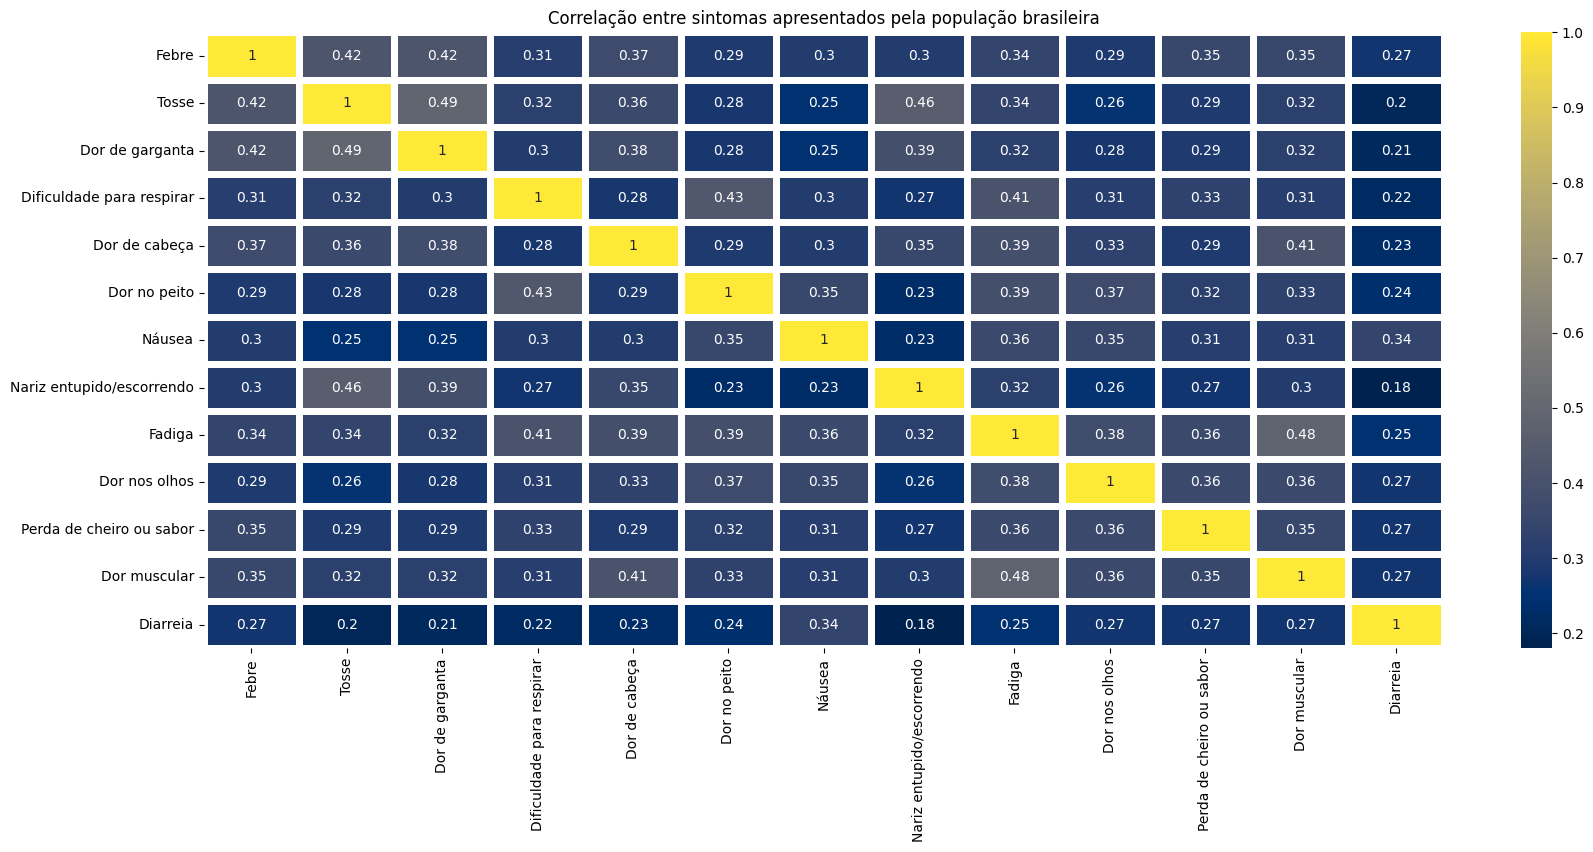

In [9]:
#Correlação entre sintomas
matrix_correlacao_sintomas = base_analise_sintomas[sintomas].copy().corr().round(2)
matrix_correlacao_sintomas.rename(index={'B0011': 'Febre', 'B0012': 'Tosse', 'B0013': 'Dor de garganta', 'B0014': 'Dificuldade para respirar', 
                          'B0015': 'Dor de cabeça', 'B0016': 'Dor no peito', 'B0017': 'Náusea', 'B0018': 'Nariz entupido/escorrendo', 
                          'B0019': 'Fadiga', 'B00110': 'Dor nos olhos', 'B00111': 'Perda de cheiro ou sabor', 'B00112': 'Dor muscular', 
                          'B00113': 'Diarreia'}, inplace=True)
matrix_correlacao_sintomas.rename(columns={'B0011': 'Febre', 'B0012': 'Tosse', 'B0013': 'Dor de garganta', 'B0014': 'Dificuldade para respirar', 
                          'B0015': 'Dor de cabeça', 'B0016': 'Dor no peito', 'B0017': 'Náusea', 'B0018': 'Nariz entupido/escorrendo', 
                          'B0019': 'Fadiga', 'B00110': 'Dor nos olhos', 'B00111': 'Perda de cheiro ou sabor', 'B00112': 'Dor muscular', 
                          'B00113': 'Diarreia'}, inplace=True)
fig, ax = plt.subplots(figsize=(20,8))
sns.heatmap(data=matrix_correlacao_sintomas, annot=True, linewidths=5, ax=ax, cmap='cividis')
plt.title('Correlação entre sintomas apresentados pela população brasileira')
plt.show()

## 2. Doenças Crônicas:
- Frequência das doênças crônicas
    - na população geral
    - nos casos que apresentaram algum sintoma
    - nos casos positivos de covid
- Correlação entre doênças crônicas e sintomas

*todas as perguntar utilizadas foram convertidas para valores booleanos, onde 1 é true e os demais valores representam false*

In [10]:
#prepado da base de dados necessária para análises doenças crônicas
base_analise_doencas = pd.DataFrame()
base_analise_doencas[sintomas + doencas + resultado_covid] = dados[sintomas + doencas + resultado_covid].copy().map(convertCategoricaltoBool)
base_analise_doencas[sintomas + doencas + resultado_covid] = base_analise_doencas[sintomas + doencas + resultado_covid].astype(bool)
base_analise_doencas['positivo_covid'] = base_analise_doencas[resultado_covid].apply(verify_covid, axis=1)
base_analise_doencas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149197 entries, 0 to 1149196
Data columns (total 23 columns):
 #   Column          Non-Null Count    Dtype
---  ------          --------------    -----
 0   B0011           1149197 non-null  bool 
 1   B0012           1149197 non-null  bool 
 2   B0013           1149197 non-null  bool 
 3   B0014           1149197 non-null  bool 
 4   B0015           1149197 non-null  bool 
 5   B0016           1149197 non-null  bool 
 6   B0017           1149197 non-null  bool 
 7   B0018           1149197 non-null  bool 
 8   B0019           1149197 non-null  bool 
 9   B00110          1149197 non-null  bool 
 10  B00111          1149197 non-null  bool 
 11  B00112          1149197 non-null  bool 
 12  B00113          1149197 non-null  bool 
 13  B0101           1149197 non-null  bool 
 14  B0102           1149197 non-null  bool 
 15  B0103           1149197 non-null  bool 
 16  B0104           1149197 non-null  bool 
 17  B0105           1149197 non

B0101  False  True 
B0101  94.13   5.87
B0102  84.81  15.19
B0103  95.01   4.99
B0104  97.17   2.83
B0105  96.99   3.01
B0106  98.91   1.09


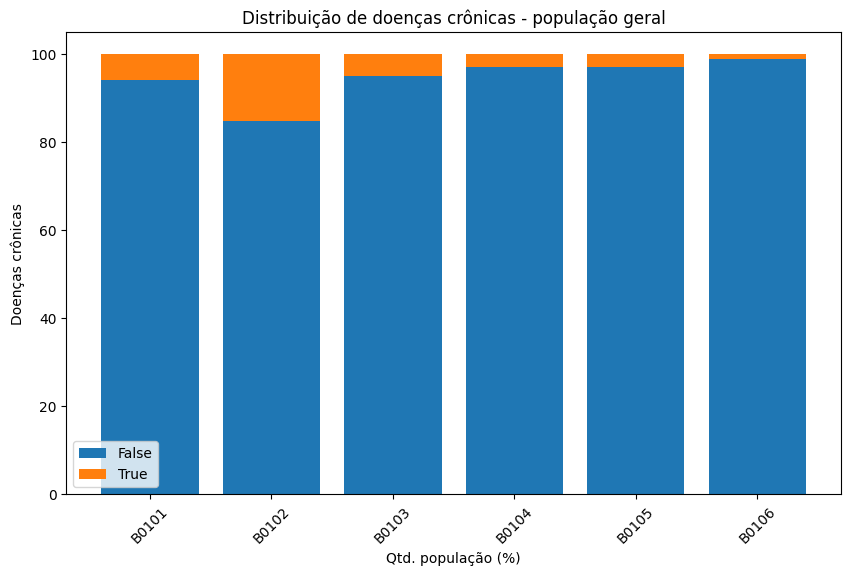

In [11]:
#Frequência dos sintomas de modo geral na população
frequencia_doencas_geral = pd.DataFrame()
for doenca in doencas:
    frequencia_doencas_geral[doenca] = base_analise_doencas[doenca].value_counts(normalize=True) * 100
frequencia_doencas_geral = frequencia_doencas_geral.T.round(2)
print(frequencia_doencas_geral)

grafico_barras_empilhadas(frequencia_doencas_geral, 'Qtd. população (%)', 'Doenças crônicas', 'Distribuição de doenças crônicas - população geral')

B0101  False  True 
B0101  90.79   9.21
B0102  77.04  22.96
B0103  88.75  11.25
B0104  93.95   6.05
B0105  91.62   8.38
B0106  97.89   2.11


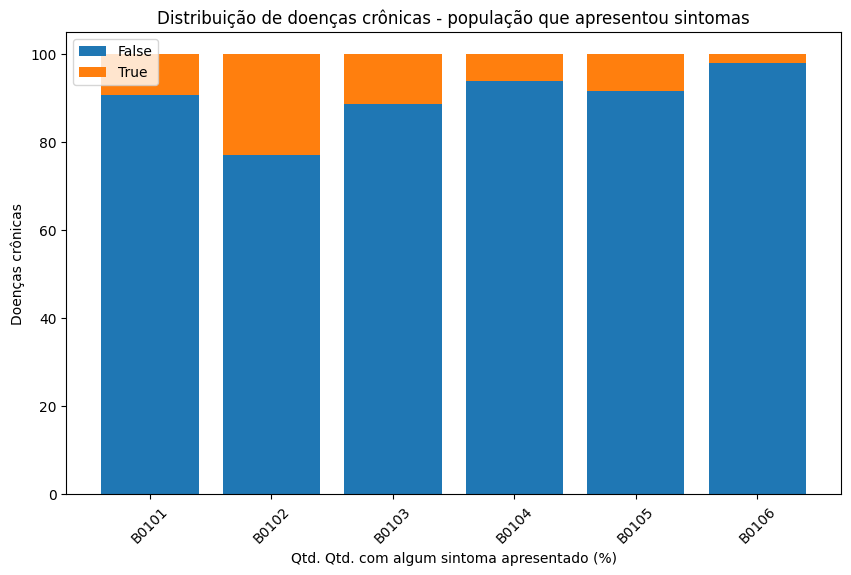

In [12]:
#Frequência das doenças crônicas nos casos que apresentam algum sintoma
base_analise_doencas_algum_sintoma = base_analise_doencas[base_analise_doencas[sintomas].any(axis=1)]
frequencia_doencas_algum_sintoma = pd.DataFrame()
for doenca in doencas:
    frequencia_doencas_algum_sintoma[doenca] = base_analise_doencas_algum_sintoma[doenca].value_counts(normalize=True) * 100
frequencia_doencas_algum_sintoma = frequencia_doencas_algum_sintoma.T.round(2)
print(frequencia_doencas_algum_sintoma)

grafico_barras_empilhadas(frequencia_doencas_algum_sintoma, 'Qtd. Qtd. com algum sintoma apresentado (%)', 'Doenças crônicas', 'Distribuição de doenças crônicas - população que apresentou sintomas')

B0101  False  True 
B0101  92.02   7.98
B0102  81.49  18.51
B0103  93.66   6.34
B0104  96.47   3.53
B0105  95.74   4.26
B0106  98.68   1.32


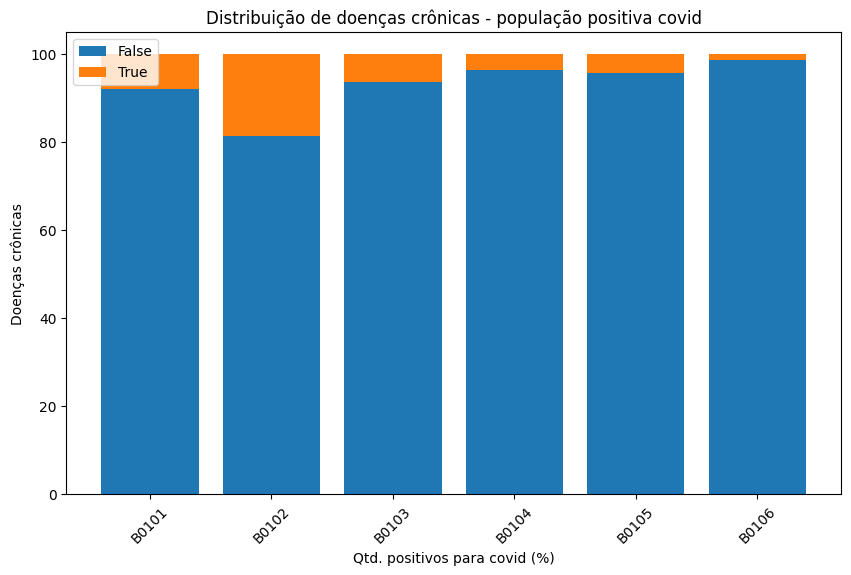

In [13]:
#Frequência das doenças crônicas nos casos positivos
base_analise_doencas_casos_positivos = base_analise_doencas[base_analise_doencas['positivo_covid'] == True]
frequencia_doencas_casos_positivos = pd.DataFrame()
for doenca in doencas:
    frequencia_doencas_casos_positivos[doenca] = base_analise_doencas_casos_positivos[doenca].value_counts(normalize=True) * 100
frequencia_doencas_casos_positivos = frequencia_doencas_casos_positivos.T.round(2)
print(frequencia_doencas_casos_positivos)

grafico_barras_empilhadas(frequencia_doencas_casos_positivos, 'Qtd. positivos para covid (%)', 'Doenças crônicas', 'Distribuição de doenças crônicas - população positiva covid')

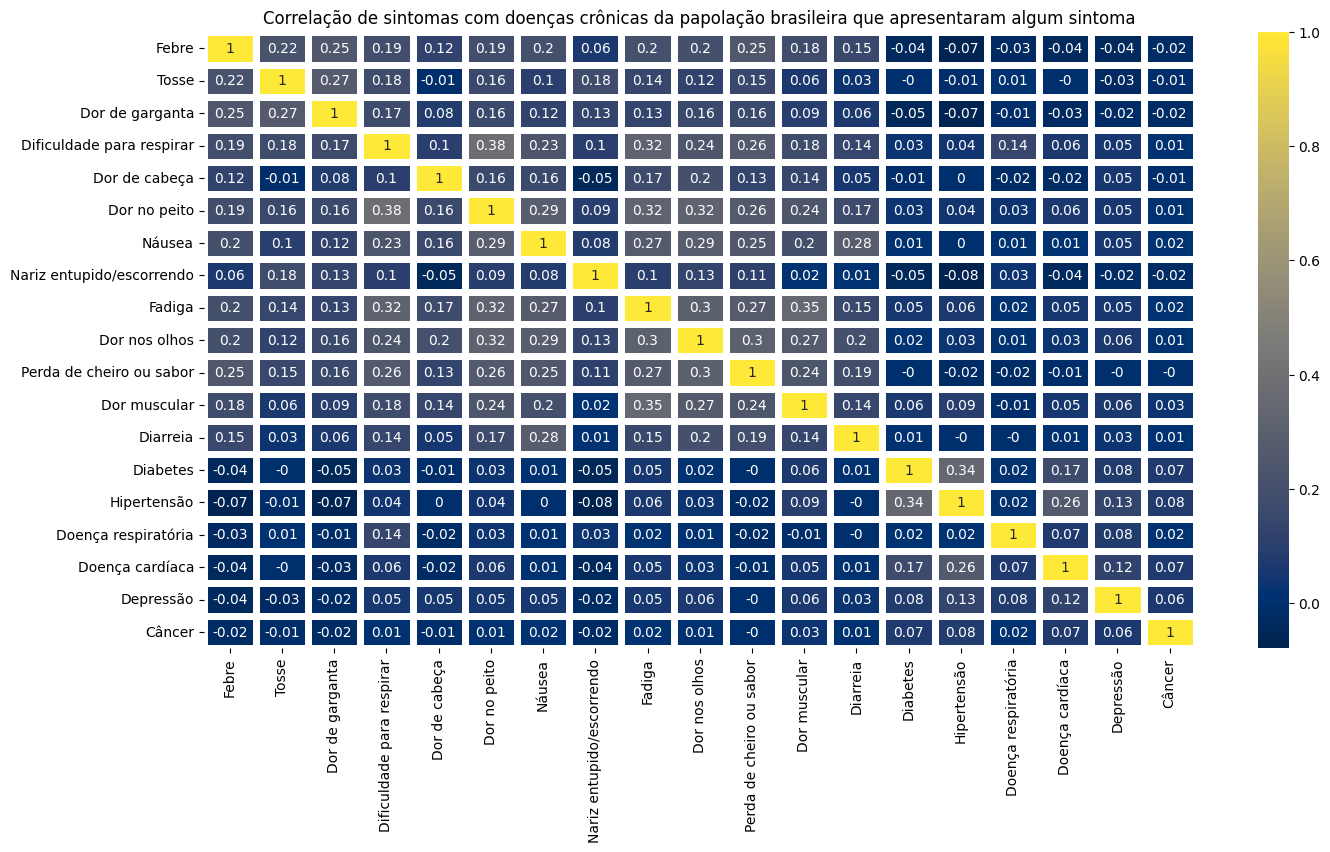

In [14]:
#Matrix de correlação das doenças crônicas com os sintomas para os casos que apresentaram algum sintoma
base_analise_doencas_algum_sintoma = base_analise_doencas[base_analise_doencas[sintomas].any(axis=1)][sintomas + doencas]
matrix_correlacao_doencas = base_analise_doencas_algum_sintoma.copy().corr().round(2)
matrix_correlacao_doencas.rename(index={'B0011': 'Febre', 'B0012': 'Tosse', 'B0013': 'Dor de garganta', 'B0014': 'Dificuldade para respirar', 
                          'B0015': 'Dor de cabeça', 'B0016': 'Dor no peito', 'B0017': 'Náusea', 'B0018': 'Nariz entupido/escorrendo', 
                          'B0019': 'Fadiga', 'B00110': 'Dor nos olhos', 'B00111': 'Perda de cheiro ou sabor', 'B00112': 'Dor muscular', 
                          'B00113': 'Diarreia', 'B0101': 'Diabetes', 'B0102': 'Hipertensão', 'B0103': 'Doença respiratória', 
                          'B0104': 'Doença cardíaca', 'B0105': 'Depressão', 'B0106': 'Câncer'}, inplace=True)
matrix_correlacao_doencas.rename(columns={'B0011': 'Febre', 'B0012': 'Tosse', 'B0013': 'Dor de garganta', 'B0014': 'Dificuldade para respirar', 
                          'B0015': 'Dor de cabeça', 'B0016': 'Dor no peito', 'B0017': 'Náusea', 'B0018': 'Nariz entupido/escorrendo', 
                          'B0019': 'Fadiga', 'B00110': 'Dor nos olhos', 'B00111': 'Perda de cheiro ou sabor', 'B00112': 'Dor muscular', 
                          'B00113': 'Diarreia', 'B0101': 'Diabetes', 'B0102': 'Hipertensão', 'B0103': 'Doença respiratória', 
                          'B0104': 'Doença cardíaca', 'B0105': 'Depressão', 'B0106': 'Câncer'}, inplace=True)
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(data=matrix_correlacao_doencas, annot=True, linewidths=5, ax=ax, cmap='cividis')
plt.title('Correlação de sintomas com doenças crônicas da papolação brasileira que apresentaram algum sintoma')
plt.show()

## 3. Internação: 
- Frequência das proviências tomadas em casos que apresentaram algum sintoma
- Frequência dos locais que buscou atendimento em casos que apresentaram algum sintoma
- Frequência de internação e intubação em casos que apresentaram algum sintoma
- Correlação com internação e intubação com sintomas em casos que apresentaram algum sintoma
- Distribuição de idades em casos de internação e intubação em casos que apresentaram algum sintoma

*todas as perguntar utilizadas foram convertidas para valores booleanos, onde 1 é true e os demais valores representam false*

In [15]:
#prepado da base de dados necessária para análises de sintomas
base_analise_internacao = pd.DataFrame()
base_analise_internacao[sintomas + doencas + providencia_tomada_sintomas + local_buscou_atendimento + internacao] = dados[sintomas + doencas + providencia_tomada_sintomas + local_buscou_atendimento + internacao].copy().map(convertCategoricaltoBool)
base_analise_internacao[sintomas + doencas + providencia_tomada_sintomas + local_buscou_atendimento + internacao] = base_analise_internacao[sintomas + doencas + providencia_tomada_sintomas + local_buscou_atendimento + internacao].astype(bool)
base_analise_internacao[idade] = dados[idade].copy().astype(int)
base_analise_internacao = base_analise_internacao[base_analise_internacao[sintomas].any(axis=1)]
base_analise_internacao.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44950 entries, 4 to 1149185
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   B0011   44950 non-null  bool 
 1   B0012   44950 non-null  bool 
 2   B0013   44950 non-null  bool 
 3   B0014   44950 non-null  bool 
 4   B0015   44950 non-null  bool 
 5   B0016   44950 non-null  bool 
 6   B0017   44950 non-null  bool 
 7   B0018   44950 non-null  bool 
 8   B0019   44950 non-null  bool 
 9   B00110  44950 non-null  bool 
 10  B00111  44950 non-null  bool 
 11  B00112  44950 non-null  bool 
 12  B00113  44950 non-null  bool 
 13  B0101   44950 non-null  bool 
 14  B0102   44950 non-null  bool 
 15  B0103   44950 non-null  bool 
 16  B0104   44950 non-null  bool 
 17  B0105   44950 non-null  bool 
 18  B0106   44950 non-null  bool 
 19  B0031   44950 non-null  bool 
 20  B0032   44950 non-null  bool 
 21  B0033   44950 non-null  bool 
 22  B0034   44950 non-null  bool 
 23  B0035   44950 

B0031  True   False
B0031  54.10  45.90
B0032   2.17  97.83
B0033  45.40  54.60
B0034   8.16  91.84
B0035   1.65  98.35
B0036   0.33  99.67
B0037   1.63  98.37


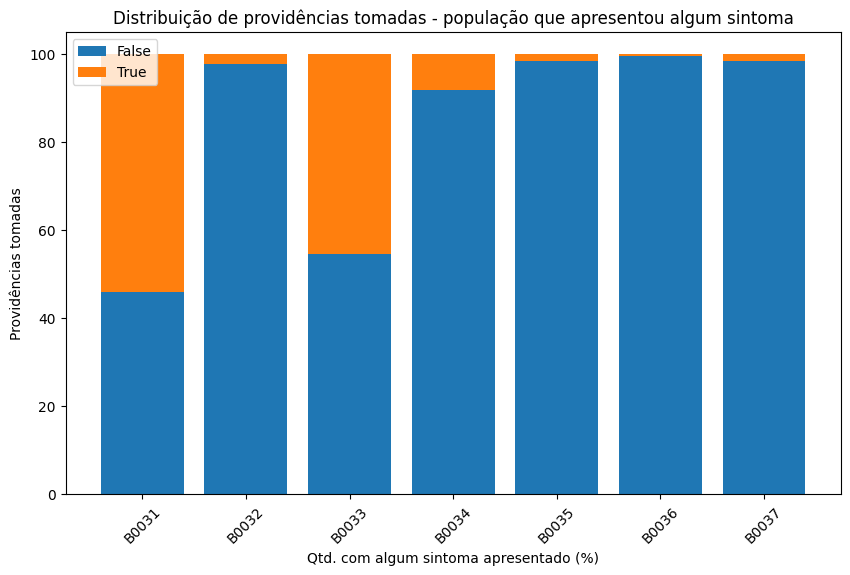

In [16]:
#frequência das providências tomadas em função dos casos que apresentaram algum sintoma
frequencia_providencias = pd.DataFrame()
for providencia in providencia_tomada_sintomas:
    frequencia_providencias[providencia] = base_analise_internacao[providencia].value_counts(normalize=True) * 100
frequencia_providencias = frequencia_providencias.T.round(2)
print(frequencia_providencias)

grafico_barras_empilhadas(frequencia_providencias, 'Qtd. com algum sintoma apresentado (%)', 'Providências tomadas', 'Distribuição de providências tomadas - população que apresentou algum sintoma')

B0044  False  True 
B0044  97.59   2.41
B0045  98.94   1.06
B0046  97.37   2.63


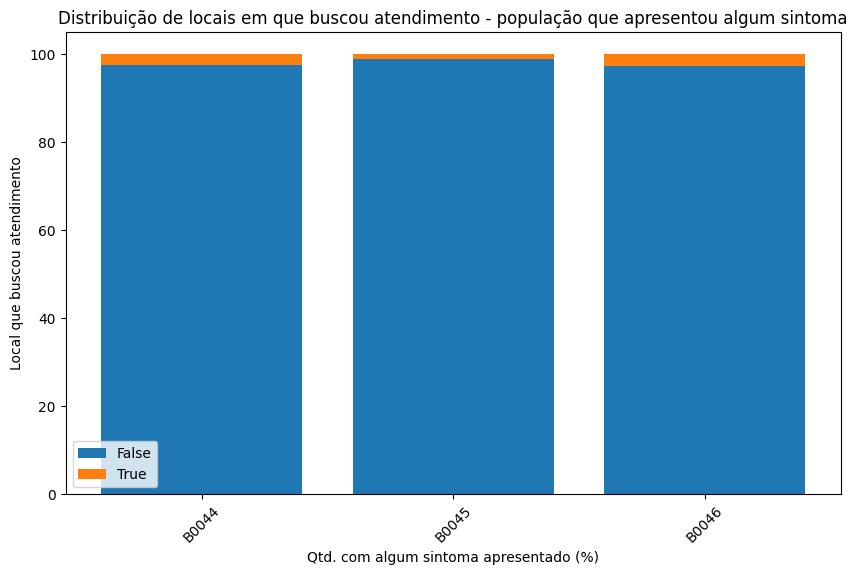

In [17]:
#frequência dos locais que buscou atendimento em função dos casos que apresentaram algum sintoma
frequencia_local_atendimento = pd.DataFrame()
for local in local_buscou_atendimento:
    frequencia_local_atendimento[local] = base_analise_internacao[local].value_counts(normalize=True) * 100
frequencia_local_atendimento = frequencia_local_atendimento.T.round(2)
print(frequencia_local_atendimento)

grafico_barras_empilhadas(frequencia_local_atendimento, 'Qtd. com algum sintoma apresentado (%)', 'Local que buscou atendimento', 'Distribuição de locais em que buscou atendimento - população que apresentou algum sintoma')

In [18]:
#frequência de internação em função dos casos que apresentaram algum sintoma - AJUSTAR PARA POSITIVO COVID APENAS
frequencia_internacao = pd.DataFrame()
for tipo_internacao in internacao:
    frequencia_internacao[tipo_internacao] = base_analise_internacao[tipo_internacao].value_counts(normalize=True) * 100
frequencia_internacao = frequencia_internacao.T.round(2)
print(frequencia_internacao)

B005  False  True 
B005  98.71   1.29
B006  99.71   0.29


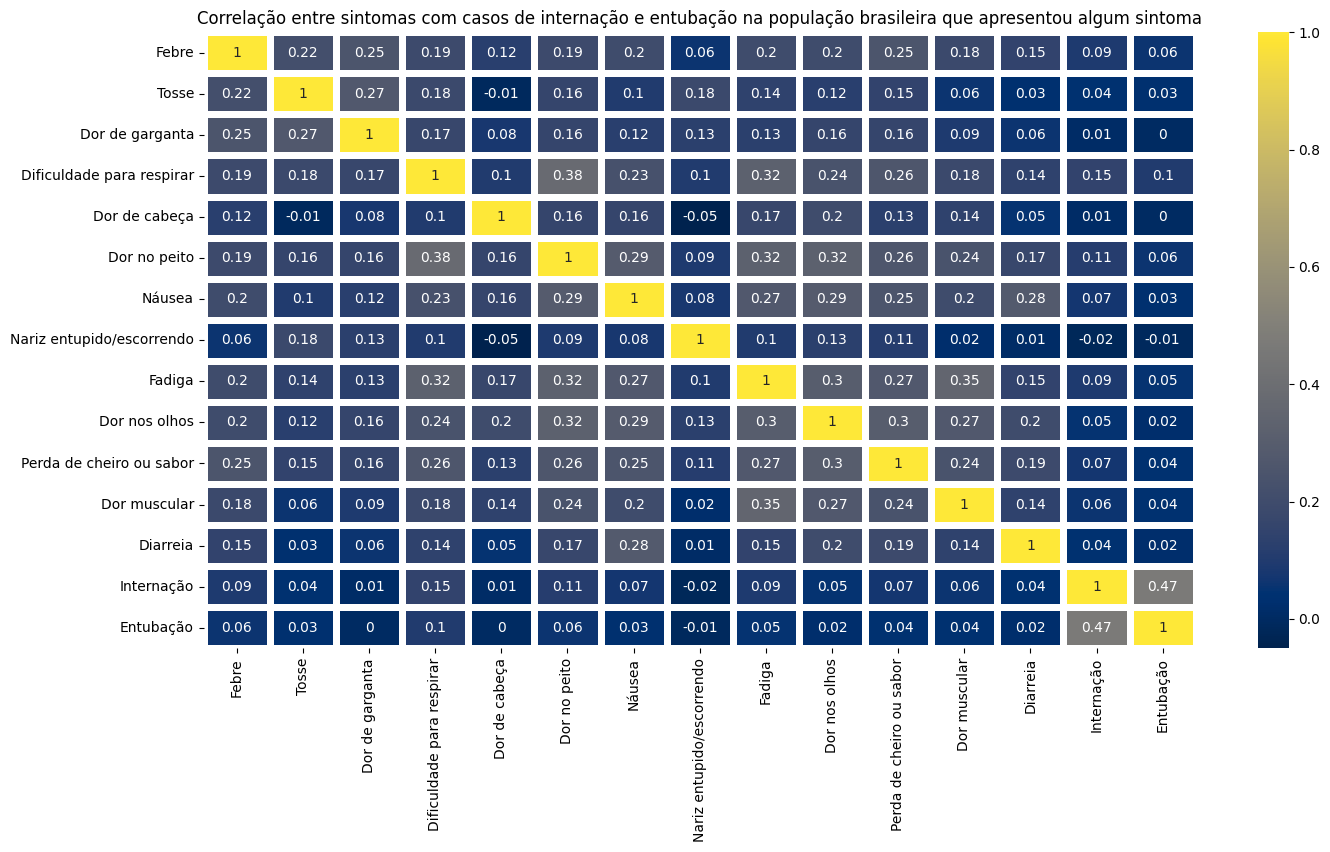

In [20]:
#correlação entre sintomas com casos de internação e entubação
matrix_correlacao_internacao = base_analise_internacao[sintomas + internacao].copy().corr().round(2)
matrix_correlacao_internacao.rename(index={'B0011': 'Febre', 'B0012': 'Tosse', 'B0013': 'Dor de garganta', 'B0014': 'Dificuldade para respirar', 
                          'B0015': 'Dor de cabeça', 'B0016': 'Dor no peito', 'B0017': 'Náusea', 'B0018': 'Nariz entupido/escorrendo', 
                          'B0019': 'Fadiga', 'B00110': 'Dor nos olhos', 'B00111': 'Perda de cheiro ou sabor', 'B00112': 'Dor muscular', 
                          'B00113': 'Diarreia', 'B005': 'Internação', 'B006': 'Entubação'}, inplace=True)
matrix_correlacao_internacao.rename(columns={'B0011': 'Febre', 'B0012': 'Tosse', 'B0013': 'Dor de garganta', 'B0014': 'Dificuldade para respirar', 
                          'B0015': 'Dor de cabeça', 'B0016': 'Dor no peito', 'B0017': 'Náusea', 'B0018': 'Nariz entupido/escorrendo', 
                          'B0019': 'Fadiga', 'B00110': 'Dor nos olhos', 'B00111': 'Perda de cheiro ou sabor', 'B00112': 'Dor muscular', 
                          'B00113': 'Diarreia', 'B005': 'Internação', 'B006': 'Entubação'}, inplace=True)
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(data=matrix_correlacao_internacao, annot=True, linewidths=5, ax=ax, cmap='cividis')
plt.title('Correlação entre sintomas com casos de internação e entubação na população brasileira que apresentou algum sintoma')
plt.show()

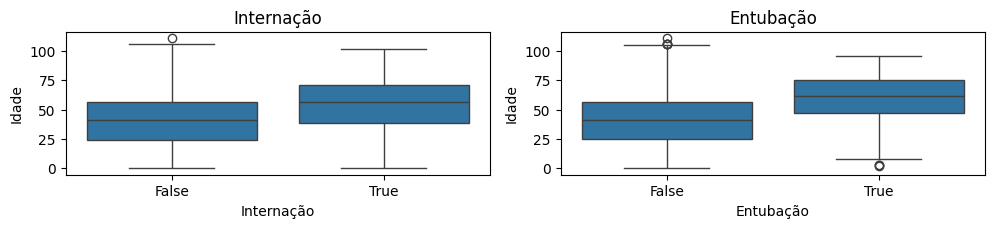

In [21]:
#Boxplo do comportamento dos sintomas em função da idade
base_internacao_idade = base_analise_internacao[internacao + [idade]].copy()
base_internacao_idade.rename(columns={'B005': 'Internação', 'B006': 'Entubação', 'A002': 'Idade'}, inplace=True)
plt.figure(figsize=(15, 10))
for i, col in enumerate(['Internação', 'Entubação']):
    plt.subplot(5, 3, i+1)
    sns.boxplot(x=base_internacao_idade[col], y=base_internacao_idade['Idade'])
    plt.title(col)
plt.tight_layout()
plt.show()

## 4. Idade e Assintomáticos:
- Distribuição da idade nos casos assintomáticos

In [22]:
#prepado da base de dados necessária para análises de idade e ausência de sintomas
base_analise_assintomaticos = pd.DataFrame()
base_analise_assintomaticos[sintomas + resultado_covid] = dados[sintomas + resultado_covid].copy().map(convertCategoricaltoBool)
base_analise_assintomaticos[sintomas + resultado_covid] = base_analise_assintomaticos[sintomas + resultado_covid].astype(bool)
base_analise_assintomaticos[idade] = dados[idade].copy().astype(int)
base_analise_assintomaticos['positivo_covid'] = base_analise_assintomaticos[resultado_covid].apply(verify_covid, axis=1)
base_analise_assintomaticos = base_analise_assintomaticos[base_analise_assintomaticos['positivo_covid'] == True]
base_analise_assintomaticos['contagem_sintomas'] = base_analise_assintomaticos[sintomas].sum(axis=1)
base_analise_assintomaticos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32922 entries, 15 to 1149152
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   B0011              32922 non-null  bool 
 1   B0012              32922 non-null  bool 
 2   B0013              32922 non-null  bool 
 3   B0014              32922 non-null  bool 
 4   B0015              32922 non-null  bool 
 5   B0016              32922 non-null  bool 
 6   B0017              32922 non-null  bool 
 7   B0018              32922 non-null  bool 
 8   B0019              32922 non-null  bool 
 9   B00110             32922 non-null  bool 
 10  B00111             32922 non-null  bool 
 11  B00112             32922 non-null  bool 
 12  B00113             32922 non-null  bool 
 13  B009B              32922 non-null  bool 
 14  B009D              32922 non-null  bool 
 15  B009F              32922 non-null  bool 
 16  A002               32922 non-null  int32
 17  positivo_covid

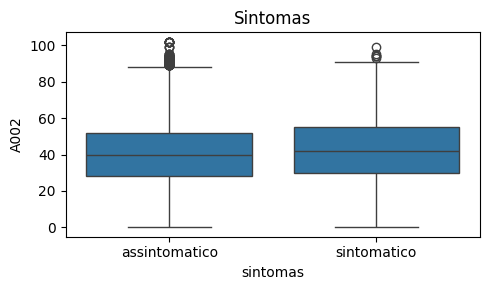

In [23]:
def verify_sintomas(contagem):
    if(int(contagem) > 0): return 'sintomatico'
    else: return 'assintomatico'

#Boxplo do comportamento dos casos assintomáticos em função da idade
df_contagem_sintomas = base_analise_assintomaticos[['contagem_sintomas', idade]]
df_contagem_sintomas['sintomas'] = base_analise_assintomaticos['contagem_sintomas'].apply(verify_sintomas)
plt.figure(figsize=(5, 3))
sns.boxplot(x=df_contagem_sintomas['sintomas'], y=df_contagem_sintomas[idade])
plt.title('Sintomas')
plt.tight_layout()
plt.show()

## 5. Questões Econômicas:
- Frequência proporcional de suspeita de covid em função da situação domiciliar (urbana ou rural)
- Frequência proporcional de suspeita de covid em função da escolaridade
- Frequência proporcional de suspeita de covid em função da faixa de renda

*todas as perguntar utilizadas foram convertidas para valores booleanos, onde 1 é true e os demais valores representam false*

*consideramos casos de suspeita caso 3 sintomas (tosse, febre e dificuldade de respirar) estejam presentes simultaneamente. (https://www.saude.ba.gov.br/temasdesaude/coronavirus/informacoes-sobre-a-covid-19/#)*

In [24]:
#prepado da base de dados necessária para análises econômicas
base_analise_economica = pd.DataFrame()
base_analise_economica[sintomas_suspeita + resultado_covid + [escolaridade] + [situacao_domicilio] + [renda]] = dados[sintomas_suspeita + resultado_covid + [escolaridade] + [situacao_domicilio] + [renda]].copy().map(convertCategoricaltoBool)
base_analise_economica[sintomas_suspeita + resultado_covid + [escolaridade] + [situacao_domicilio] + [renda]] = base_analise_economica[sintomas_suspeita + resultado_covid + [escolaridade] + [situacao_domicilio] + [renda]].astype(bool)
base_analise_economica[[escolaridade] + [situacao_domicilio] + [renda]] = dados[[escolaridade] + [situacao_domicilio] + [renda]].copy().fillna('-1')
base_analise_economica['positivo_covid'] = base_analise_economica[resultado_covid].apply(verify_covid, axis=1)
base_analise_economica = base_analise_economica[(base_analise_economica['positivo_covid'] == True) | (base_analise_economica[sintomas_suspeita].all(axis=1))]
base_analise_economica.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33982 entries, 15 to 1149152
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   B0011           33982 non-null  bool  
 1   B0012           33982 non-null  bool  
 2   B0014           33982 non-null  bool  
 3   B009B           33982 non-null  bool  
 4   B009D           33982 non-null  bool  
 5   B009F           33982 non-null  bool  
 6   A005            33982 non-null  object
 7   V1022           33982 non-null  object
 8   C01011          33982 non-null  object
 9   positivo_covid  33982 non-null  bool  
dtypes: bool(7), object(3)
memory usage: 1.3+ MB


In [25]:
#frequência proporcional de casos positivos em função da situação domiciliar (urbana ou rural)
absoluto = pd.DataFrame()
absoluto[situacao_domicilio] = base_analise_economica[situacao_domicilio].value_counts()
absoluto['total'] = dados[situacao_domicilio].fillna('-1').value_counts()
absoluto['freq'] = (absoluto[situacao_domicilio] / absoluto['total']) * 100
absoluto = absoluto.T.round(2)
print(absoluto)

V1022          1          2
V1022   29479.00    4503.00
total  875200.00  273997.00
freq        3.37       1.64


In [26]:
#frequência proporcional de casos positivos em função da escolaridade
absoluto = pd.DataFrame()
absoluto[escolaridade] = base_analise_economica[escolaridade].value_counts()
absoluto['total'] = dados[escolaridade].fillna('-1').value_counts()
absoluto['freq'] = (absoluto[escolaridade] / absoluto['total']) * 100
absoluto = absoluto.T.round(2)
absoluto

A005,5,2,7,6,4,3,8,1
A005,9948.00,6884.00,6007.00,2842.00,2740.00,2028.00,1879.0,1654.00
total,256040.00,387986.00,107441.00,59678.00,107635.00,76092.00,30290.0,124035.00
freq,3.89,1.77,5.59,4.76,2.55,2.67,6.2,1.33


In [27]:
#frequência proporcional de casos positivos em função da faixa de renda
absoluto = pd.DataFrame()
absoluto[renda] = base_analise_economica[renda].value_counts()
absoluto['total'] = dados[renda].fillna('-1').value_counts()
absoluto['freq'] = (absoluto[renda] / absoluto['total']) * 100
absoluto = absoluto.T.round(2)
absoluto

C01011,-1,4,5,6,2,7,3,1,0,8
C01011,14636.00,8045.00,5341.00,3828.00,700.0,655.00,425.00,296.00,49.00,7.00
total,726462.00,189736.00,103125.00,57729.00,30397.0,7720.00,16718.00,14405.00,2848.00,47.00
freq,2.01,4.24,5.18,6.63,2.3,8.48,2.54,2.05,1.72,14.89


## 6. Comportamento Populacional:
- Frequência de suspeita de covid em função do estado da federação
    - proporcional considerando o total da população do estado da federação
    - de casos suspeita de covid do estado da federação em comparação com suspeita de covid com todos os estados da federação
- Frequência do local que buscou atendimento em casos de suspeita de covid

*todas as perguntar utilizadas foram convertidas para valores booleanos, onde 1 é true e os demais valores representam false*

*consideramos casos de suspeita caso 3 sintomas (tosse, febre e dificuldade de respirar) estejam presentes simultaneamente. (https://www.saude.ba.gov.br/temasdesaude/coronavirus/informacoes-sobre-a-covid-19/#)*

In [28]:
#prepado da base de dados necessária para análises de comportamento da população
base_analise_comportamento = pd.DataFrame()
base_analise_comportamento[sintomas_suspeita + resultado_covid + local_buscou_atendimento + [renda] + [estado]] = dados[sintomas_suspeita + resultado_covid + local_buscou_atendimento + [renda] + [estado]].copy().map(convertCategoricaltoBool)
base_analise_comportamento[sintomas_suspeita + resultado_covid + local_buscou_atendimento + [renda] + [estado]] = base_analise_comportamento[sintomas_suspeita + resultado_covid + local_buscou_atendimento + [renda] + [estado]].astype(bool)
base_analise_comportamento[[renda, estado]] = dados[[renda, estado]].copy().fillna('-1')
base_analise_comportamento['positivo_covid'] = base_analise_comportamento[resultado_covid].apply(verify_covid, axis=1)
base_analise_comportamento = base_analise_comportamento[(base_analise_comportamento['positivo_covid'] == True) | (base_analise_comportamento[sintomas_suspeita].all(axis=1))]
base_analise_comportamento.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33982 entries, 15 to 1149152
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   B0011           33982 non-null  bool  
 1   B0012           33982 non-null  bool  
 2   B0014           33982 non-null  bool  
 3   B009B           33982 non-null  bool  
 4   B009D           33982 non-null  bool  
 5   B009F           33982 non-null  bool  
 6   B0044           33982 non-null  bool  
 7   B0045           33982 non-null  bool  
 8   B0046           33982 non-null  bool  
 9   C01011          33982 non-null  object
 10  sigla_uf        33982 non-null  object
 11  positivo_covid  33982 non-null  bool  
dtypes: bool(10), object(2)
memory usage: 1.1+ MB


In [29]:
#frequencia proporcional de suspeita de covid por estado geral
absoluto = pd.DataFrame()
absoluto[estado] = base_analise_comportamento[estado].value_counts()
absoluto['total'] = dados[estado].value_counts()
absoluto['freq'] = (absoluto[estado] / absoluto['total']) * 100
absoluto = absoluto.T.round(2)
absoluto

sigla_uf,SP,MA,RJ,GO,SC,CE,MG,AM,ES,PA,...,AL,SE,PE,PB,RN,AC,MS,RO,TO,AP
sigla_uf,2321.00,2226.00,2225.00,2113.00,1722.00,1609.00,1564.00,1561.00,1460.00,1363.00,...,1034.0,870.00,859.00,836.00,727.00,713.00,676.00,639.00,598.00,550.00
total,98021.00,61200.00,87405.00,41977.00,70990.00,50536.00,103096.00,31355.00,47511.00,35764.00,...,34450.0,24216.00,50811.00,29687.00,23552.00,18834.00,26434.00,16622.00,15446.00,7677.00
freq,2.37,3.64,2.55,5.03,2.43,3.18,1.52,4.98,3.07,3.81,...,3.0,3.59,1.69,2.82,3.09,3.79,2.56,3.84,3.87,7.16


In [30]:
#frequencia de suspeita de covid por estado somente em casos de suspeita
absoluto = pd.DataFrame()
absoluto[estado] = base_analise_comportamento[estado].value_counts()
absoluto['total'] = base_analise_comportamento[estado].count()
absoluto['freq'] = (absoluto[estado] / absoluto['total']) * 100
absoluto = absoluto.T.round(2)
absoluto

sigla_uf,SP,MA,RJ,GO,SC,CE,MG,AM,ES,PA,...,AL,SE,PE,PB,RN,AC,MS,RO,TO,AP
sigla_uf,2321.00,2226.00,2225.00,2113.00,1722.00,1609.00,1564.0,1561.00,1460.0,1363.00,...,1034.00,870.00,859.00,836.00,727.00,713.0,676.00,639.00,598.00,550.00
total,33982.00,33982.00,33982.00,33982.00,33982.00,33982.00,33982.0,33982.00,33982.0,33982.00,...,33982.00,33982.00,33982.00,33982.00,33982.00,33982.0,33982.00,33982.00,33982.00,33982.00
freq,6.83,6.55,6.55,6.22,5.07,4.73,4.6,4.59,4.3,4.01,...,3.04,2.56,2.53,2.46,2.14,2.1,1.99,1.88,1.76,1.62


In [31]:
#frequência do local que buscou atendimento em casos de suspeita de covid
distribuicao = base_analise_comportamento[local_buscou_atendimento].value_counts().reset_index()
absoluto = pd.DataFrame()
for collum in distribuicao.columns[:-1]:
        absoluto[collum] = [distribuicao[distribuicao[collum] == True]['count'].sum()]
absoluto['NA'] = distribuicao[~distribuicao[absoluto.columns].any(axis=1)]['count'].sum()
absoluto = absoluto.T.round(2)
absoluto['freq'] = ((absoluto.loc[local_buscou_atendimento + ['NA']] / absoluto.sum()[0]) * 100)
absoluto

,0,freq
B0044,288,0.845666
B0045,172,0.505051
B0046,442,1.297862
NA,33154,97.351421


## 7. Análise de perfil de casos positivos com base nos sintomas (MCA + K-means):
a ideia é identificar os sintomas mais relevantes nos casos positivos de covid

*todas as perguntar utilizadas foram convertidas para valores booleanos, onde 1 é true e os demais valores representam false*

In [32]:
#prepado da base de dados necessária para análises de cluster dos sintomas
base_analise_cluster = pd.DataFrame()
base_analise_cluster[sintomas + resultado_covid + doencas] = dados[sintomas + resultado_covid + doencas].copy().map(convertCategoricaltoBool)
base_analise_cluster[sintomas + resultado_covid + doencas] = base_analise_cluster[sintomas + resultado_covid + doencas].astype(bool)
base_analise_cluster['positivo_covid'] = base_analise_cluster[resultado_covid].apply(verify_covid, axis=1)
base_analise_cluster = base_analise_cluster[base_analise_cluster['positivo_covid'] == True]
base_analise_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32922 entries, 15 to 1149152
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   B0011           32922 non-null  bool 
 1   B0012           32922 non-null  bool 
 2   B0013           32922 non-null  bool 
 3   B0014           32922 non-null  bool 
 4   B0015           32922 non-null  bool 
 5   B0016           32922 non-null  bool 
 6   B0017           32922 non-null  bool 
 7   B0018           32922 non-null  bool 
 8   B0019           32922 non-null  bool 
 9   B00110          32922 non-null  bool 
 10  B00111          32922 non-null  bool 
 11  B00112          32922 non-null  bool 
 12  B00113          32922 non-null  bool 
 13  B009B           32922 non-null  bool 
 14  B009D           32922 non-null  bool 
 15  B009F           32922 non-null  bool 
 16  B0101           32922 non-null  bool 
 17  B0102           32922 non-null  bool 
 18  B0103           32922 non-nu

In [33]:
#Análise MCA (Análise de Correspondência Múltipla) nos dados positivos de COVID. Tentando reduzir a dimensão dos dados e visualizar caracteristicas impactantes
variaveis_categoricas = base_analise_cluster[sintomas + doencas].copy()
mca = prince.MCA(n_components=2)
mca = mca.fit(variaveis_categoricas)
variaveis_mca = mca.transform(variaveis_categoricas)
variaveis_mca.describe().round(2)

,0,1
count,32922.00,32922.00
mean,-0.00,-0.00
std,0.62,0.28
min,-0.18,-0.30
25%,-0.18,-0.14
50%,-0.18,-0.14
75%,-0.16,0.16
max,4.13,2.08


In [34]:
# Identificar outliers
centroide = variaveis_mca.mean()
variaveis_mca['distancia'] = np.sqrt((variaveis_mca[0] - centroide[0])**2 + 
                                  (variaveis_mca[1] - centroide[1])**2)
limite = variaveis_mca['distancia'].quantile(0.95)
outliers = variaveis_mca[variaveis_mca['distancia'] > limite]
resultados_mca = variaveis_mca[variaveis_mca['distancia'] <= limite]
print(outliers)

                0         1  distancia
668      2.017318 -0.157627   2.023467
1424     1.330428 -0.174427   1.341814
2711     1.675918 -0.206183   1.688553
2855     4.093930  0.330713   4.107266
3006     4.073064 -0.243653   4.080346
...           ...       ...        ...
1145184  4.073064 -0.243653   4.080346
1145828  2.148677 -0.141089   2.153304
1147724  3.312409  0.916352   3.436823
1148174  1.376373 -0.242415   1.397557
1148694 -0.129218  1.546388   1.551777

[1647 rows x 3 columns]


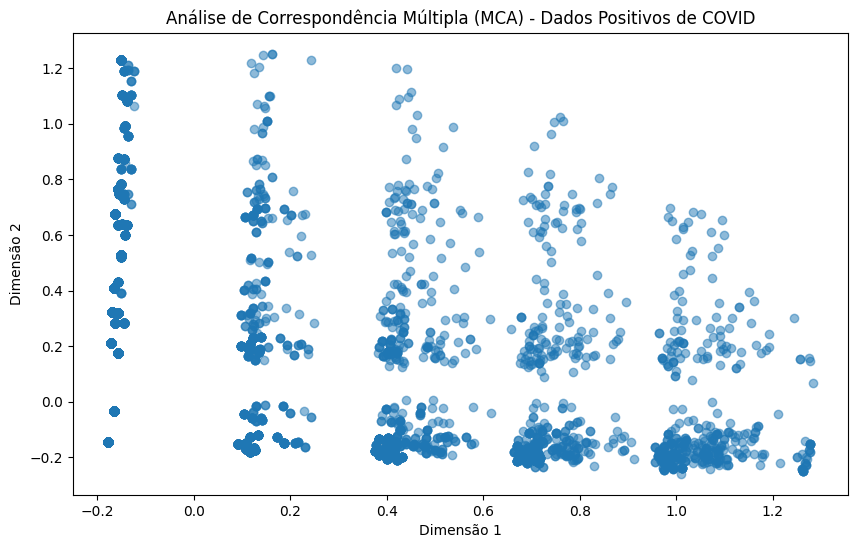

In [35]:
# Scatterplot das duas primeiras dimensões da MCA
plt.figure(figsize=(10, 6))
plt.scatter(resultados_mca[0], resultados_mca[1], alpha=0.5)
plt.xlabel('Dimensão 1')
plt.ylabel('Dimensão 2')
plt.title('Análise de Correspondência Múltipla (MCA) - Dados Positivos de COVID')
plt.show()

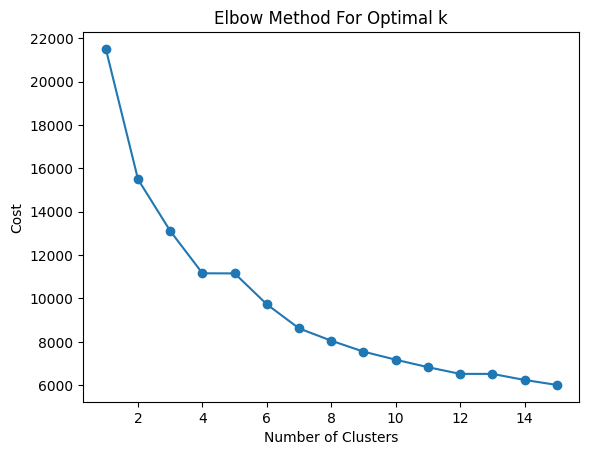

In [36]:
#método elbow para identificação de clusters
df_elbow = resultados_mca[[0, 1]].copy()
cost = []
for num_clusters in range(1, 16):
    kmodes = KModes(n_clusters=num_clusters, init='Cao', n_init=5, verbose=0)
    kmodes.fit_predict(df_elbow)
    cost.append(kmodes.cost_)

plt.plot(range(1, 16), cost, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()


Número de clusters: 2, Silhouette Score: 0.707
Número de clusters: 3, Silhouette Score: 0.810
Número de clusters: 4, Silhouette Score: 0.859
Número de clusters: 5, Silhouette Score: 0.858
Número de clusters: 6, Silhouette Score: 0.861
Número de clusters: 7, Silhouette Score: 0.866
Número de clusters: 8, Silhouette Score: 0.877
Número de clusters: 9, Silhouette Score: 0.885
Número de clusters: 10, Silhouette Score: 0.879
Número de clusters: 11, Silhouette Score: 0.891
Número de clusters: 12, Silhouette Score: 0.888
Número de clusters: 13, Silhouette Score: 0.892
Número de clusters: 14, Silhouette Score: 0.922
Número de clusters: 15, Silhouette Score: 0.925


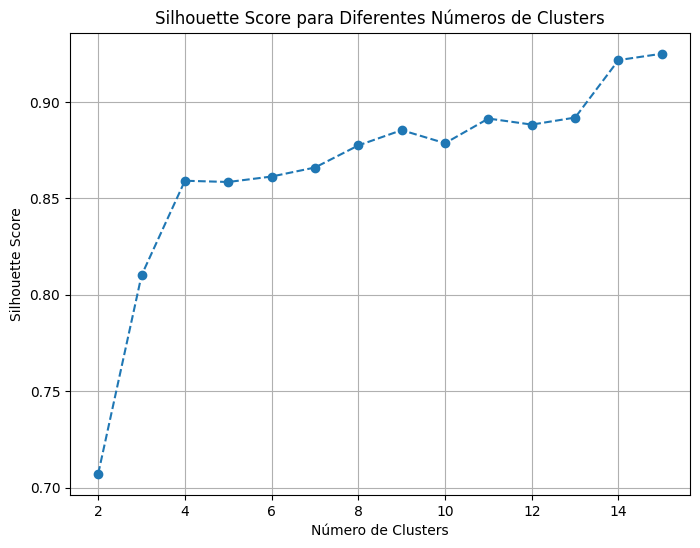

In [37]:
#silhouette para identificação de clusters
range_n_clusters = list(range(2, 16))
silhouette_scores = []
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(resultados_mca[[0, 1]])
    silhouette_avg = silhouette_score(resultados_mca[[0, 1]], cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Número de clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.3f}")

plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para Diferentes Números de Clusters')
plt.grid(True)
plt.show()

In [38]:
# Definir o número de clusters
kmeans = KMeans(n_clusters=15, random_state=42)
clusters = kmeans.fit_predict(resultados_mca[[0, 1]])
resultados_mca['cluster'] = clusters
consolidado_cluster = base_analise_cluster.loc[resultados_mca.index].copy()
consolidado_cluster[[0 , 1 , 'distancia', 'cluster']] = resultados_mca
consolidado_cluster.rename(columns={0: 'x', 1: 'y'}, inplace=True)
consolidado_cluster.head()

,B0011,B0012,B0013,B0014,B0015,B0016,B0017,B0018,B0019,B00110,...,B0102,B0103,B0104,B0105,B0106,positivo_covid,x,y,distancia,cluster
15,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,-0.177306,-0.143683,0.228215,0
16,False,True,True,False,True,False,False,False,False,False,...,False,False,False,False,False,True,0.683384,-0.187176,0.708554,7
17,False,True,False,False,False,False,False,True,False,False,...,True,True,False,False,False,True,0.734132,0.775923,1.068179,10
20,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,True,-0.170629,0.210279,0.270798,3
31,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,-0.177306,-0.143683,0.228215,0


In [39]:
# contagem de tuplas por cluster
consolidado_cluster.groupby('cluster').size().reset_index(name='counts').T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
counts,20525,1707,338,3567,324,460,236,321,570,1421,115,221,191,1189,90


In [40]:
# desvio padrão nas dimensões do resultado MCA
analise_cluster = consolidado_cluster.groupby('cluster')[['x', 'y']].agg(['median', 'std']).T.round(2)
analise_cluster

cluster     0     1     2     3     4     5     6     7     8     9     10  \
x median -0.18 -0.16  0.14 -0.17  1.03  0.41 -0.14  0.71  0.12 -0.17  0.51   
  std     0.00  0.01  0.16  0.01  0.09  0.04  0.06  0.05  0.03  0.01  0.17   
y median -0.14  0.68  0.21  0.21 -0.19 -0.17  0.99 -0.17 -0.15  0.32  0.70   
  std     0.00  0.07  0.07  0.01  0.05  0.04  0.08  0.04  0.04  0.04  0.15   

cluster     11    12    13    14  
x median -0.15  0.88 -0.16  0.13  
  std     0.06  0.17  0.00  0.03  
y median  1.23  0.21 -0.03  0.67  
  std     0.05  0.12  0.00  0.09

In [41]:
#análise de relevância de variável
media_x, media_y = analise_cluster.loc[('x', 'median'), :].describe().loc['75%'], analise_cluster.loc[('y', 'median'), :].describe().loc['75%']
clusters_x = analise_cluster.T[analise_cluster.T['x', 'median'] >= media_x].reset_index()
clusters_y = analise_cluster.T[analise_cluster.T['y', 'median'] >= media_y].reset_index()

In [42]:
#Junção de cluster relevantes em x e y
clusters_xy = pd.concat([clusters_y, clusters_x], ignore_index=True)
clusters_xy.T

0     1      2      3     4     5      6      7
cluster         1.00  6.00  10.00  11.00  4.00  7.00  10.00  12.00
x       median -0.16 -0.14   0.51  -0.15  1.03  0.71   0.51   0.88
        std     0.01  0.06   0.17   0.06  0.09  0.05   0.17   0.17
y       median  0.68  0.99   0.70   1.23 -0.19 -0.17   0.70   0.21
        std     0.07  0.08   0.15   0.05  0.05  0.04   0.15   0.12

In [43]:
#Remoção de clusters com alto desvio padrão
mean_stdX, mean_stdY = clusters_xy['x', 'std'].mean(), clusters_xy['y', 'std'].mean()
std_stdX, std_stdY = clusters_xy['x', 'std'].std(), clusters_xy['y', 'std'].std()
limite_stdX, limite_stdY = (mean_stdX + 2 * std_stdX), (mean_stdY + 2 * std_stdY)
clusters_a_excluir = clusters_xy[(clusters_xy['x', 'std'] > limite_stdX) | (clusters_xy['y', 'std'] > limite_stdY)]
clusters_a_excluir

Empty DataFrame
Columns: [(cluster, ), (x, median), (x, std), (y, median), (y, std)]
Index: []

In [44]:
#Média da frequência de sintomas nos clusters relevantes 
dados_graficos_cluster = consolidado_cluster.groupby('cluster')[sintomas].mean().loc[clusters_xy['cluster']]
dados_graficos_cluster

,B0011,B0012,B0013,B0014,B0015,B0016,B0017,B0018,B0019,B00110,B00111,B00112,B00113
cluster,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.004237,0.004237,0.000000,0.000000,0.008475,0.000000,0.000000,0.000000,0.000000,0.000000,0.012712,0.016949,0.000000
10,0.165217,0.304348,0.139130,0.156522,0.330435,0.078261,0.069565,0.234783,0.330435,0.017391,0.182609,0.382609,0.052174
11,0.000000,0.004525,0.000000,0.000000,0.009050,0.004525,0.000000,0.000000,0.009050,0.000000,0.004525,0.013575,0.000000
4,0.589506,0.500000,0.370370,0.163580,0.611111,0.086420,0.095679,0.283951,0.342593,0.083333,0.413580,0.456790,0.092593
7,0.433022,0.373832,0.342679,0.109034,0.470405,0.074766,0.065421,0.261682,0.224299,0.021807,0.255452,0.299065,0.056075
10,0.165217,0.304348,0.139130,0.156522,0.330435,0.078261,0.069565,0.234783,0.330435,0.017391,0.182609,0.382609,0.052174
12,0.356021,0.445026,0.282723,0.162304,0.549738,0.094241,0.104712,0.235602,0.356021,0.094241,0.267016,0.403141,0.141361


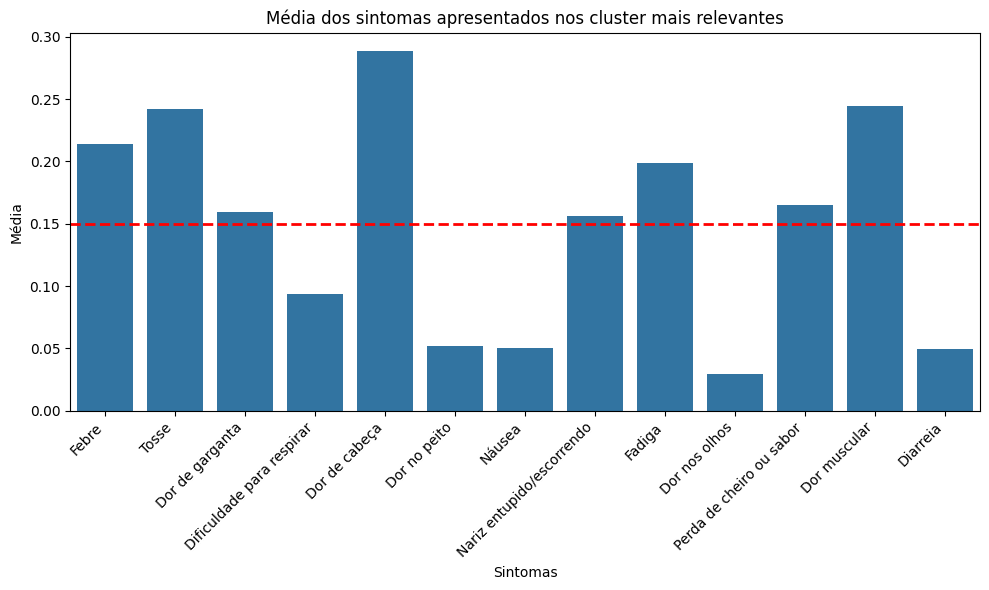

In [45]:
media_dados = dados_graficos_cluster.mean()
media_dados.rename(index={'B0011': 'Febre', 'B0012': 'Tosse', 'B0013': 'Dor de garganta', 'B0014': 'Dificuldade para respirar', 
                          'B0015': 'Dor de cabeça', 'B0016': 'Dor no peito', 'B0017': 'Náusea', 'B0018': 'Nariz entupido/escorrendo', 
                          'B0019': 'Fadiga', 'B00110': 'Dor nos olhos', 'B00111': 'Perda de cheiro ou sabor', 'B00112': 'Dor muscular', 
                          'B00113': 'Diarreia'}, inplace=True)
plt.figure(figsize=(10, 6))
sns.barplot(x=media_dados.index, y=media_dados.values)
plt.xticks(rotation=45, ha='right')
media_geral = media_dados.mean()
plt.axhline(y=media_geral, color='red', linestyle='--', linewidth=2, label=f'Média Geral: {media_geral:.2f}')
plt.title('Média dos sintomas apresentados nos cluster mais relevantes')
plt.xlabel('Sintomas')
plt.ylabel('Média')
plt.tight_layout()
plt.show()